In [2]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import mne

In [3]:
#Takes a period as list of samples, desired segment length in seconds and the sampling frequency, returns a list of segments of the period {{},{},...{}}
def splitperiod(period, segment_length, sampling_freq):
    segments = []
    current_segment = []
    sample_seglen = math(segment_length * sampling_freq)
    for i, sample in enumerate(period):
        current_segment.append(sample)
        if i%sample_seglen == 0 and i!=0:
            segments.append(current_segment)
            current_segment = []
    return segments

def find_index(x,threshold):
    size_list = []
    start_list = []
    i_start = 0
    i_end = 0
    for i,val in enumerate(x):
        if val >= threshold:
            if i_start == 0:
                i_start = i
                start_list.append(i)
            if i == len(x)-1:
                i_end = i
        else:
            if i_start != 0 and i_end == 0:
                i_end = i
                size_list.append(i_end-i_start)
                #reseting index start and end 
                i_start = 0 
                i_end = 0
    return start_list,size_list                       


Extracting EDF parameters from d:\Epilepsi spike detection\Data\chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\johan\AppData\Local\Temp\ipykernel_26284\2609949255.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf('Data/chb01_04.edf').get_data()


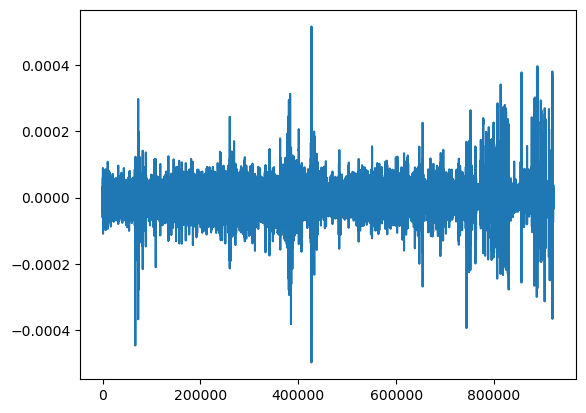

In [4]:
raw_data = mne.io.read_raw_edf('Data/chb01_04.edf').get_data()
plt.plot(raw_data[1])

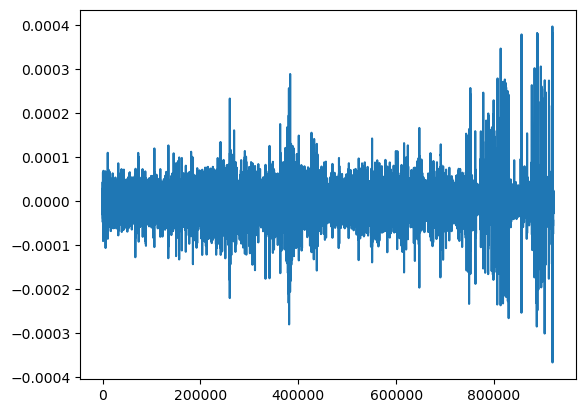

In [5]:

sos = scipy.signal.butter(20, 10, 'lp', fs=256, output='sos')
filtered = scipy.signal.sosfilt(sos, raw_data[1])
plt.plot(filtered)

9987


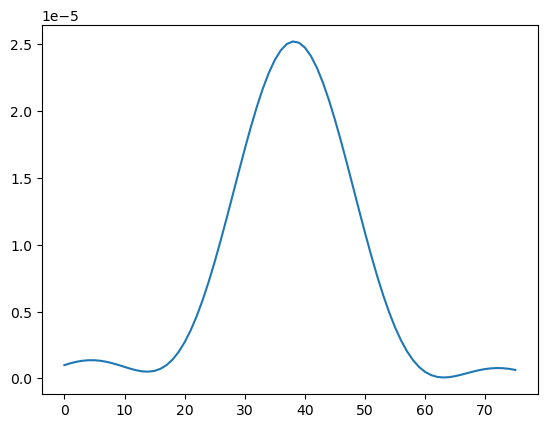

In [15]:
#stores the index where the signal starts going over a certain treshold and the length of that part of the signal
i0,clustersize = find_index(filtered,0.00001)

#picks out the peaks that meet the time criteria 
i0_spikes = []
spike_cluster = []
for i,size in enumerate(clustersize):
    if size > np.floor(256*0.02) and size < np.floor(256*0.07):
        spike_cluster.append(size)
        i0_spikes.append(i0[i])
        
# extracting a 0.3 seconds around the spike so as to have the full spike and wave form
time_to_extract = 0.3*256
extracted = []
for n,val in enumerate(clustersize):
    extracted_spike = filtered[math.floor((i0[n]+clustersize[n]*0.5)-time_to_extract*0.5):math.floor((i0[n]+clustersize[n]*0.5)+time_to_extract*0.5)]
    extracted.append(extracted_spike)

# working
# scaled signal averager, takes n signals and averages them to 1 signal that is a average of all of them.
Sum = [[0]*int(time_to_extract)]
Sum = Sum[0]
signal = []
for n in extracted:
    signal.append(n)
print(len(signal))
N = len(signal)

truth = N-1

i = 0
while i < np.floor(time_to_extract):  
    n = 0
    while n < truth:
        Sum[i] = Sum[i] + signal[n][i]
        n +=1
    Sum[i] = Sum[i]/N
    i += 1
plt.plot(Sum)

In [49]:
#save pattern
import csv
a_list = Sum

a_file = open("Pattern_chb01_04.csv", "w")
a_writer = csv.writer(a_file)
a_writer.writerow(a_list)
a_file.close()